In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame

In [3]:
from datetime import datetime
from datetime import timedelta
from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
help(Measurement)


Help on class measurement in module sqlalchemy.ext.automap:

class measurement(Base)
 |  measurement(**kwargs)
 |  
 |  Base class for an "automap" schema.
 |  
 |  The :class:`.AutomapBase` class can be compared to the "declarative base"
 |  class that is produced by the :func:`.declarative.declarative_base`
 |  function.  In practice, the :class:`.AutomapBase` class is always used
 |  as a mixin along with an actual declarative base.
 |  
 |  A new subclassable :class:`.AutomapBase` is typically instantated
 |  using the :func:`.automap_base` function.
 |  
 |  .. seealso::
 |  
 |      :ref:`automap_toplevel`
 |  
 |  Method resolution order:
 |      measurement
 |      Base
 |      AutomapBase
 |      sqlalchemy.ext.declarative.api.Base
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, **kwargs)
 |      A simple constructor that allows initialization from kwargs.
 |      
 |      Sets attributes on the constructed instance using the names and
 |      va

# Exploratory Climate Analysis

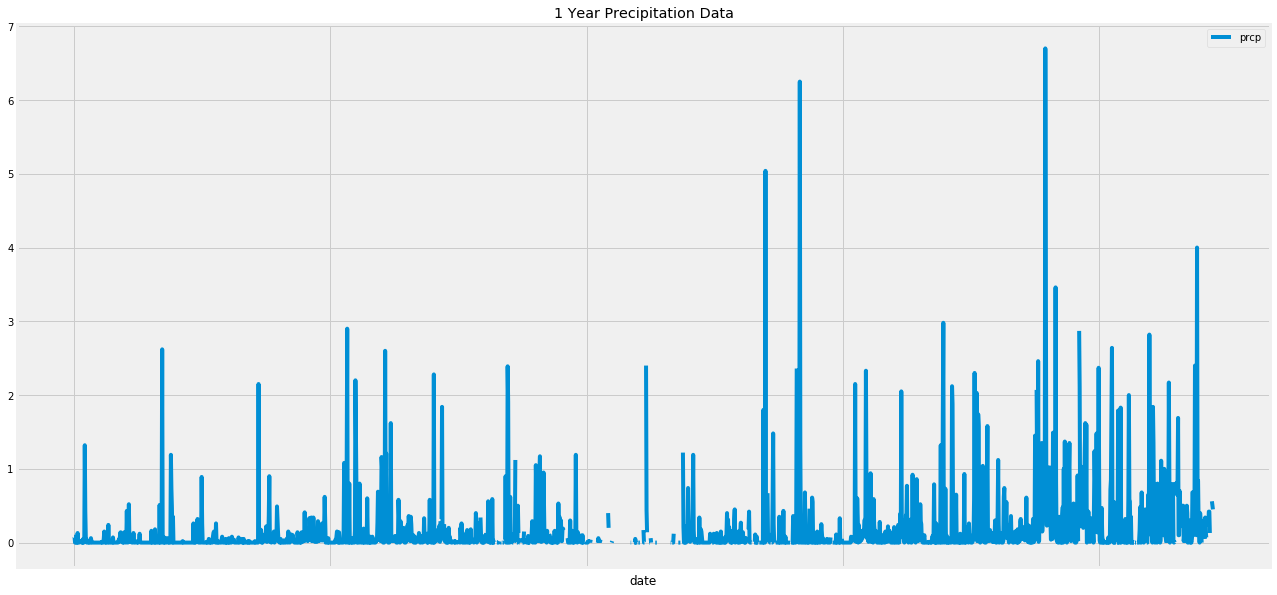

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# precip_data = session.query(Measurement.date, Measurement.prcp)

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
date = datetime.strptime('2017-08-23', '%Y-%m-%d')
year_ago = date - timedelta(days=365)
# print(year_ago)
# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date > year_ago).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_data_df = pd.DataFrame(precip_data)
precip_data_df.reindex(columns=['date'])
# Sort the dataframe by date
precip_data_df.sort_values(['date'])
# print(df)
# Use Pandas Plotting with Matplotlib to plot the data

precip_data_df.plot(x="date", y="prcp", grid=True, figsize=(20,10),
              title="1 Year Precipitation Data")
plt.savefig("Images/Precipitation_Data.png")
plt.show()

![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_data_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
# help(Station)
stn_count = session.query(Measurement.station).distinct().count()
print(f"There are {stn_count} stations available")

There are 9 stations available


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
most_active = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
# List the stations and the counts in descending order.
most_active_df = pd.DataFrame(most_active,columns=['station','count'])
print("Below are the 5 most active stations")
print("------------------------------------")
print(most_active_df[0:5])
print("------------------------------------")
print(f"Station {most_active_df.iloc[0,0]} has the highest number of observations")

Below are the 5 most active stations
------------------------------------
       station  count
0  USC00519281   2772
1  USC00519397   2724
2  USC00513117   2709
3  USC00519523   2669
4  USC00516128   2612
------------------------------------
Station USC00519281 has the highest number of observations


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
stn_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                          filter(Measurement.station == most_active_df.iloc[0,0]).all()
print(stn_stats)

[(54.0, 85.0, 71.66378066378067)]


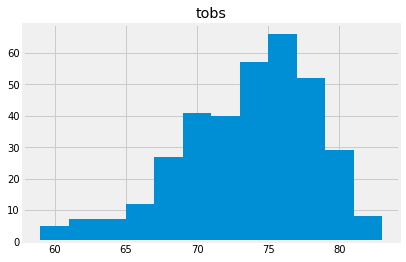

In [16]:
# Choose the station with the highest number of temperature observations.
highest_temp_count = session.query(Measurement.station, func.count(Measurement.tobs)).\
group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
# print(highest_temp_count)
# # Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.date, Measurement.tobs).\
filter(Measurement.date > year_ago).filter(Measurement.station == highest_temp_count[0]).all()
# print(temp_data)
# Save the query results as a Pandas DataFrame
temp_data_df = pd.DataFrame(temp_data)
# print(temp_data_df)
hist = temp_data_df.hist(bins=12)
plt.savefig("Images/station_histogram.png")
plt.show()


![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.

    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
 
    Returns:
        TMIN, TAVE, and TMAX
    """
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
            filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()    
    
# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = input('Enter first date of your trip in YYYY-MM-DD format ')
end_date = input('Enter last date of your trip in YYYY-MM-DD format ')
trip_stats = calc_temps(start_date, end_date)

Enter first date of your trip in YYYY-MM-DD format 2016-12-31
Enter last date of your trip in YYYY-MM-DD format 2017-01-01


   tmin       tavg  tmax
0  62.0  68.818182  74.0


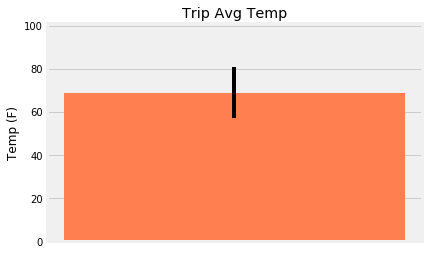

In [22]:
# Plot the results from your previous query as a bar chart. 
trip_stats_df = pd.DataFrame(trip_stats, columns = ['tmin','tavg','tmax'])
print(trip_stats_df)
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = [trip_stats_df['tmin'] - trip_stats_df['tmax']]
fig1, ax1 = plt.subplots()
ax1.bar(0,trip_stats_df['tavg'], yerr=error, color="coral", align='center', ecolor='black')
ax1.set_ylim(0,101)
ax1.set_title('Trip Avg Temp')
ax1.set_ylabel('Temp (F)')
ax1.get_xaxis().set_visible(False)
fig1.savefig("Images/Temperature.png")

In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain_data = session.query(Measurement.station,Station.name, Station.latitude,
                         Station.longitude, Station.elevation, Measurement.prcp).\
filter(Measurement.station == Station.station).\
filter(Measurement.date >= '2016-12-17').\
filter(Measurement.date <= '2017-01-01').order_by(Measurement.prcp.desc()).all()
print(rain_data)


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`


In [ ]:
precip_data_df.to_dict('index')